In [51]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GRU, SimpleRNN, Conv1D, GlobalMaxPooling1D, MultiHeadAttention, Dropout, Flatten, Bidirectional
from tensorflow.keras.regularizers import l2
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import KFold
from model_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data load and preprocessing

### Load data - full and summarised versions

In [13]:
# Load data

train_labels = np.load("../data/npy/train_labels.npy")
test_labels = np.load("../data/npy/test_labels.npy")

train_texts = np.load("../data/npy/train_texts.npy", allow_pickle=True)
test_texts = np.load("../data/npy/test_texts.npy", allow_pickle=True)

train_texts_gpt2 = np.load("../data/npy/train_texts_gpt2.npy", allow_pickle=True)
test_texts_gpt2 = np.load("../data/npy/test_texts_gpt2.npy", allow_pickle=True)

train_texts_pagerank = np.load("../data/npy/train_texts_pagerank.npy", allow_pickle=True)
test_texts_pagerank = np.load("../data/npy/test_texts_pagerank.npy", allow_pickle=True)

### Preprocess using Keras tokeniser

#### Get optimal parameters

Found 41671 unique tokens.
Mean sequence length: 381.96330022075057
Maximum sequence length: 1981
Chosen max_len based on 95th percentile: 668


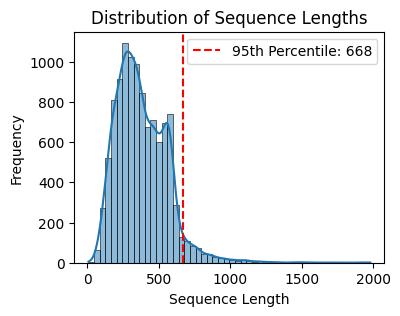

In [14]:
# Get optimal parameters
max_len, vocab_size = get_optimal_params(train_texts)

Found 20287 unique tokens.
Mean sequence length: 74.11147902869757
Maximum sequence length: 577
Chosen max_len based on 95th percentile: 131


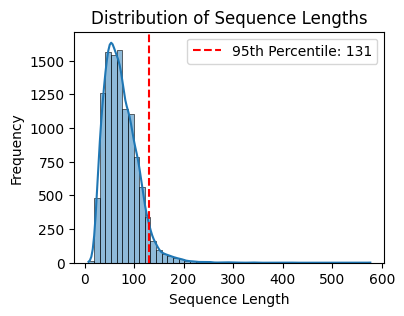

In [15]:
# Get optimal parameters for summarised texts
max_len_gpt2, vocab_size_gpt2 = get_optimal_params(train_texts_gpt2)

Found 24718 unique tokens.
Mean sequence length: 126.92135761589404
Maximum sequence length: 594
Chosen max_len based on 95th percentile: 208


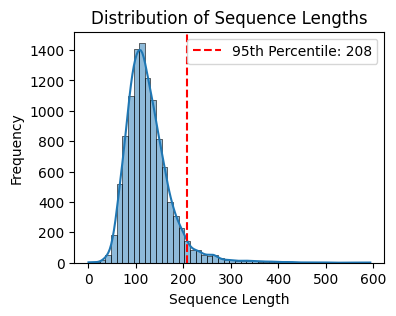

In [16]:
# Get optimal parameters for pagerank texts
max_len_pagerank, vocab_size_pagerank = get_optimal_params(train_texts_pagerank)

#### Get tokenised sequences for train and test data

In [24]:
# Preprocess sequences
train_sequences, test_sequences = preprocess_sequences(train_texts, test_texts, num_words=vocab_size, maxlen=650)

In [25]:
# Preprocess GPT-2 summarised sequences
train_sequences_gpt2, test_sequences_gpt2 = preprocess_sequences(train_texts_gpt2, test_texts_gpt2, num_words=vocab_size_gpt2, maxlen=130)

In [26]:
# Preprocess Pagerank summarised sequences
train_sequences_pagerank, test_sequences_pagerank = preprocess_sequences(train_texts_pagerank, test_texts_pagerank, num_words=vocab_size_pagerank, maxlen=200)

## Model Evaluation

### Original data

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.5406 - loss: 0.6889
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 447ms/step - accuracy: 0.6769 - loss: 0.6075
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step - accuracy: 0.7866 - loss: 0.4681
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - accuracy: 0.8524 - loss: 0.3484
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 510ms/step - accuracy: 0.9169 - loss: 0.2226
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 529ms/step - accuracy: 0.9581 - loss: 0.1264
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 522ms/step - accuracy: 0.9794 - loss: 0.0649
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 513ms/step - accuracy: 0.9845 - loss: 0.0483
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 513ms/step - accuracy: 0.9901 - loss: 0.0347
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - accuracy: 0.9909 - loss: 0.0321
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step

=== Evaluation Metrics ===
Accuracy: 0.5943
Precision: 0.2372
Recall: 0.6470
F1_score: 0.3471
Roc

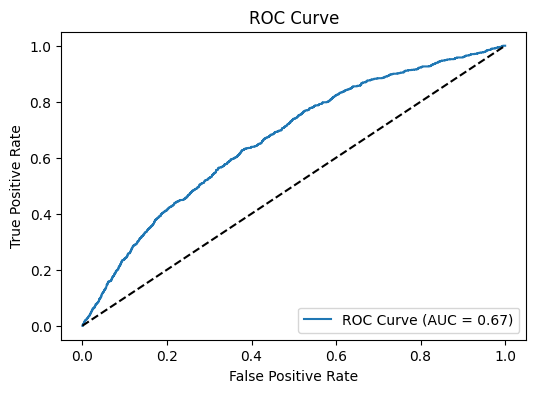

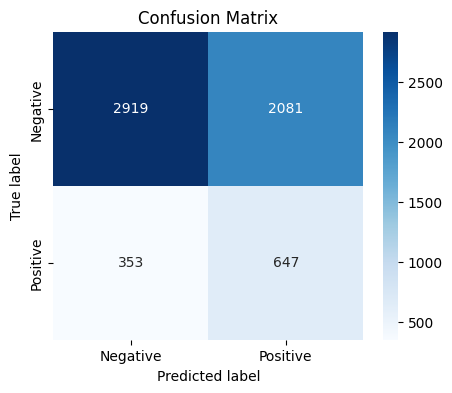

In [9]:
# Test RNN
train_and_test('RNN', train_sequences, train_labels, test_sequences, test_labels, input_shape=(650,), vocab_size=vocab_size, embedding_dim=128)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.5857 - loss: 0.6690
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 666s 8s/step - accuracy: 0.6462 - loss: 0.6411
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.6785 - loss: 0.6100
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.7067 - loss: 0.5804
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 310s 4s/step - accuracy: 0.7334 - loss: 0.5513
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.7926 - loss: 0.4609
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.8666 - loss: 0.3290
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.9046 - loss: 0.2500
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.9064 - loss: 0.2255
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.9466 - loss: 0.1477
188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 362ms/step

=== Evaluation Metrics ===
Accuracy: 0.6642
Precision: 0.2993
Recall: 0.7570
F1_score: 0.4290
Roc_auc: 0.7761


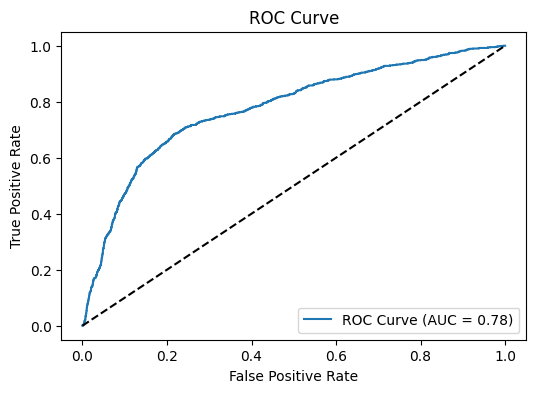

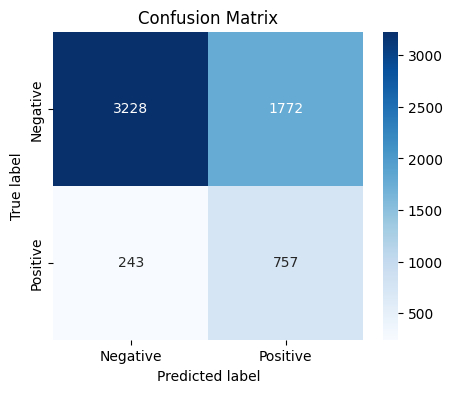

In [10]:
# Test RNN with Attention
train_and_test('RNN_Attention', train_sequences, train_labels, test_sequences, test_labels, input_shape=(650,), vocab_size=vocab_size, embedding_dim=128)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.5361 - loss: 0.6886
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.6725 - loss: 0.6301
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7414 - loss: 0.5270
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8256 - loss: 0.4131
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9029 - loss: 0.2831
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9602 - loss: 0.1659
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9907 - loss: 0.0784
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9986 - loss: 0.0364
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9993 - loss: 0.0180
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9998 - loss: 0.0101
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Evaluation Metrics ===
Accuracy: 0.6540
Precision: 0.2889
Recall: 0.7360
F1_score: 0.4149
Roc_auc: 0.7543


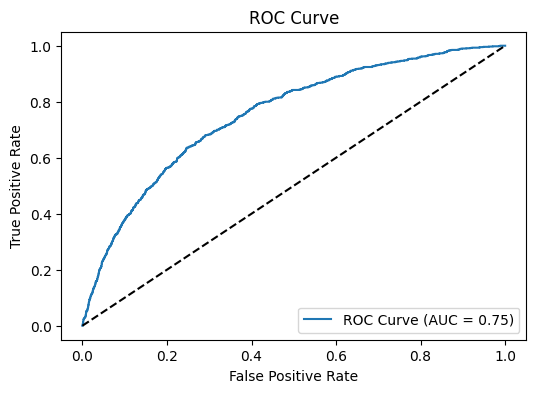

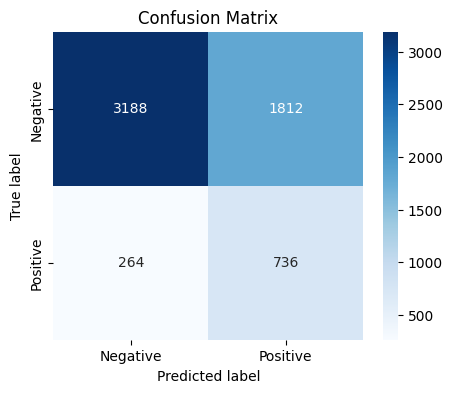

In [11]:
# Test CNN
train_and_test('CNN', train_sequences, train_labels, test_sequences, test_labels, input_shape=(650,), vocab_size=vocab_size, embedding_dim=128)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 629s 7s/step - accuracy: 0.5943 - loss: 0.6676
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.6747 - loss: 0.6098
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7535 - loss: 0.4911
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7758 - loss: 0.4588
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1219s 14s/step - accuracy: 0.8040 - loss: 0.4155
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8441 - loss: 0.3628
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1146s 14s/step - accuracy: 0.8823 - loss: 0.2792
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 668s 8s/step - accuracy: 0.9044 - loss: 0.2347
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9301 - loss: 0.1876
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9590 - loss: 0.1260
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step

=== Evaluation Metrics ===
Accuracy: 0.7727
Precision: 0.4153
Recall: 0.8930
F1_score: 0.5670
Roc_auc: 0.8772


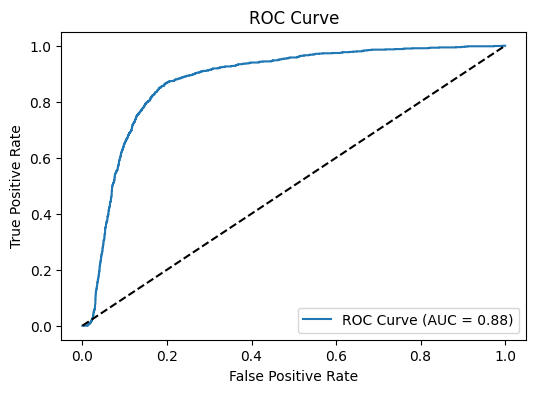

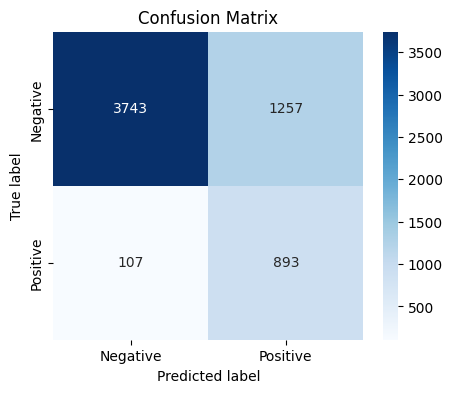

In [12]:
# Test CNN with Attention
train_and_test('CNN_Attention', train_sequences, train_labels, test_sequences, test_labels, input_shape=(650,), vocab_size=vocab_size, embedding_dim=128)

### GPT-2 summarised data

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5487 - loss: 0.6849
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.7232 - loss: 0.5492
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8483 - loss: 0.3516
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.9214 - loss: 0.2109
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.9644 - loss: 0.1132
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9683 - loss: 0.0905
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.9724 - loss: 0.0818
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9851 - loss: 0.0488
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.9949 - loss: 0.0181
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.9988 - loss: 0.0073
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

=== Evaluation Metrics ===
Accuracy: 0.7713
Precision: 0.4127
Recall: 0.8790
F1_score: 0.5617
Roc_auc: 0.8926


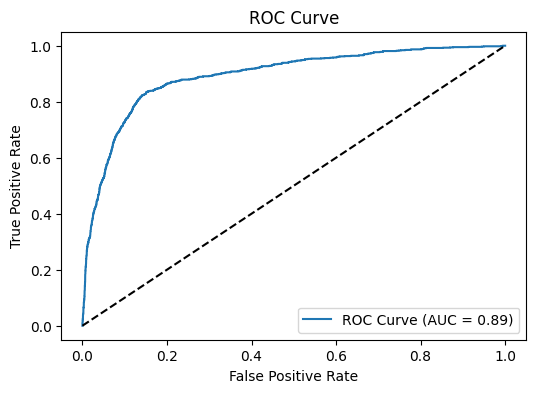

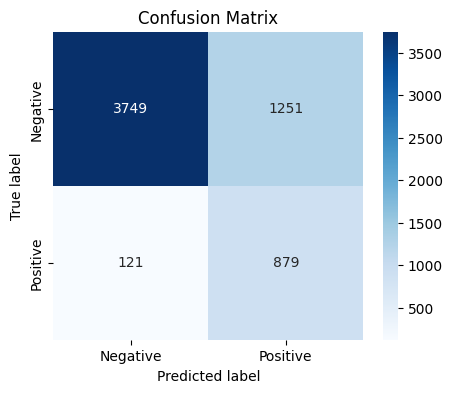

In [13]:
# Test RNN with GPT-2 summarised sequences
train_and_test('RNN', train_sequences_gpt2, train_labels, test_sequences_gpt2, test_labels, input_shape=(130,), vocab_size=vocab_size_gpt2, embedding_dim=128)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.5746 - loss: 0.6741
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 275ms/step - accuracy: 0.6970 - loss: 0.5823
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 24s 287ms/step - accuracy: 0.7541 - loss: 0.4890
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step - accuracy: 0.8055 - loss: 0.4093
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 293ms/step - accuracy: 0.8738 - loss: 0.3140
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.9211 - loss: 0.2231
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 300ms/step - accuracy: 0.9579 - loss: 0.1370
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.9762 - loss: 0.0863
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 319ms/step - accuracy: 0.9829 - loss: 0.0635
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 310ms/step - accuracy: 0.9899 - loss: 0.0462
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step

=== Evaluation Metrics ===
Accuracy: 0.6195
Precision: 0.2927
Recall: 0.9060
F1_score: 0.4425
Roc

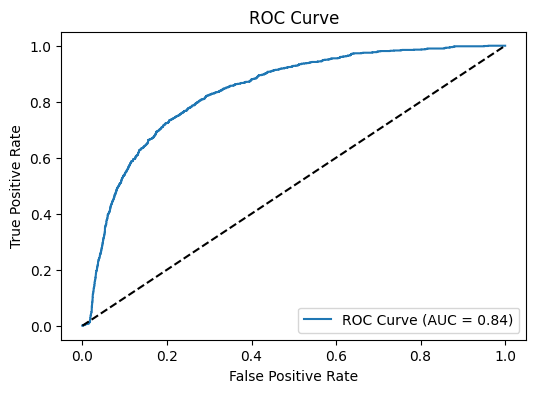

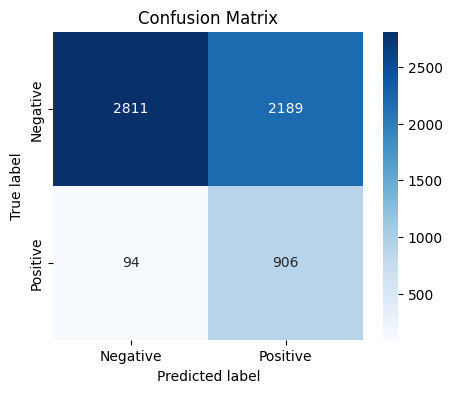

In [14]:
# Test RNN with Attention with GPT-2 summarised sequences
train_and_test('RNN_Attention', train_sequences_gpt2, train_labels, test_sequences_gpt2, test_labels, input_shape=(130,), vocab_size=vocab_size_gpt2, embedding_dim=128)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5696 - loss: 0.6721
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7178 - loss: 0.5444
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7918 - loss: 0.4610
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8639 - loss: 0.3523
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9284 - loss: 0.2329
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9724 - loss: 0.1266
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9932 - loss: 0.0609
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9983 - loss: 0.0301
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9998 - loss: 0.0154
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0083
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step

=== Evaluation Metrics ===
Accuracy: 0.6772
Precision: 0.3234
Recall: 0.8580
F1_score: 0.4698
Roc_auc: 0.8454


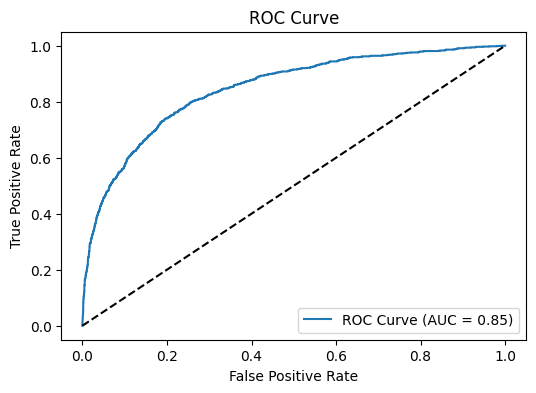

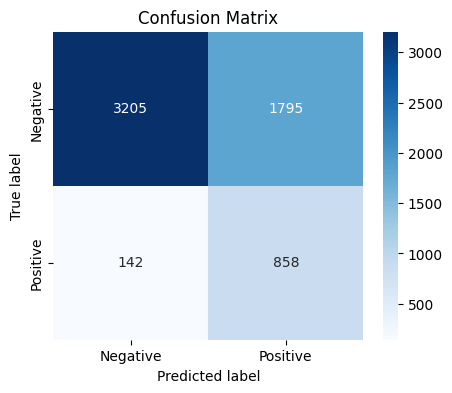

In [15]:
# Test CNN with GPT-2 summarised sequences
train_and_test('CNN', train_sequences_gpt2, train_labels, test_sequences_gpt2, test_labels, input_shape=(130,), vocab_size=vocab_size_gpt2, embedding_dim=128)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.5846 - loss: 0.6698
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.7226 - loss: 0.5438
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.7537 - loss: 0.4906
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.7833 - loss: 0.4501
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.8270 - loss: 0.3767
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.8622 - loss: 0.3205
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.9060 - loss: 0.2341
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.9209 - loss: 0.1992
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.9572 - loss: 0.1217
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.9742 - loss: 0.0739
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step

=== Evaluation Metrics ===
Accuracy: 0.6785
Precision: 0.3261
Recall: 0.8710
F1_score: 0.4745
Roc

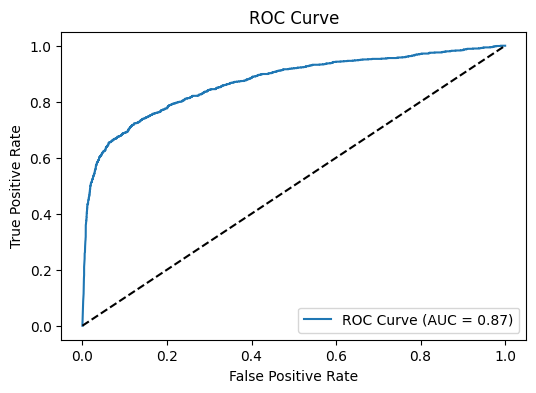

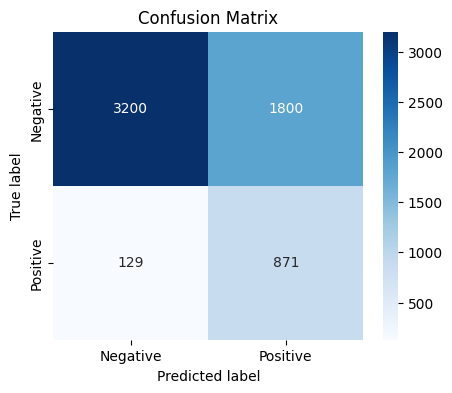

In [16]:
# Test CNN with Attention with GPT-2 summarised sequences
train_and_test('CNN_Attention', train_sequences_gpt2, train_labels, test_sequences_gpt2, test_labels, input_shape=(130,), vocab_size=vocab_size_gpt2, embedding_dim=128)

In [ ]:
# Test Transformer with GPT-2 summarised sequences
train_and_test('Transformer', train_sequences_gpt2, train_labels, test_sequences_gpt2, test_labels, input_shape=(130,), vocab_size=vocab_size_gpt2, embedding_dim=128)

### Pagerank summarised data

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.5379 - loss: 0.6895
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.6870 - loss: 0.5896
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.8056 - loss: 0.4353
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.9014 - loss: 0.2525
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.9457 - loss: 0.1502
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.9731 - loss: 0.0874
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.9794 - loss: 0.0613
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.9842 - loss: 0.0510
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - accuracy: 0.9946 - loss: 0.0198
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.9915 - loss: 0.0262
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step

=== Evaluation Metrics ===
Accuracy: 0.5652
Precision: 0.2480
Recall: 0.7920
F1_score: 0.3778
Roc

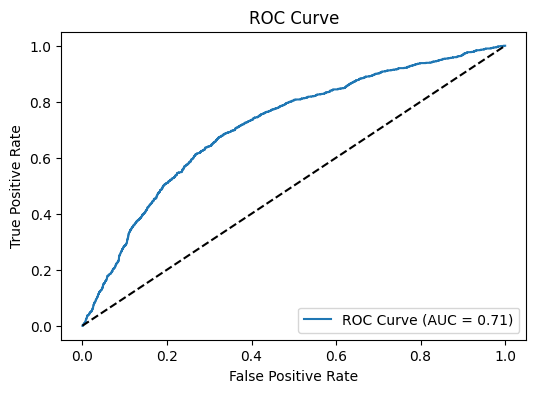

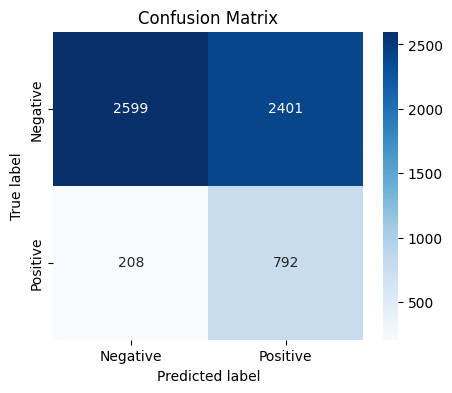

In [17]:
# Test RNN with Pagerank summarised texts
train_and_test('RNN', train_sequences_pagerank, train_labels, test_sequences_pagerank, test_labels, input_shape=(200,), vocab_size=vocab_size_pagerank, embedding_dim=128)

/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - accuracy: 0.5465 - loss: 0.6856
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 490ms/step - accuracy: 0.6597 - loss: 0.6148
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.7440 - loss: 0.5185
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.7722 - loss: 0.4732
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 47s 553ms/step - accuracy: 0.8182 - loss: 0.4048
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 505ms/step - accuracy: 0.8537 - loss: 0.3553
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 500ms/step - accuracy: 0.9117 - loss: 0.2249
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 43s 503ms/step - accuracy: 0.9418 - loss: 0.1715
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 47s 548ms/step - accuracy: 0.9693 - loss: 0.0928
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 59s 695ms/step - accuracy: 0.9779 - loss: 0.0696
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step

=== Evaluation Metrics ===
Accuracy: 0.5742
Precision: 0.2498
Recall: 0.7760
F1_score

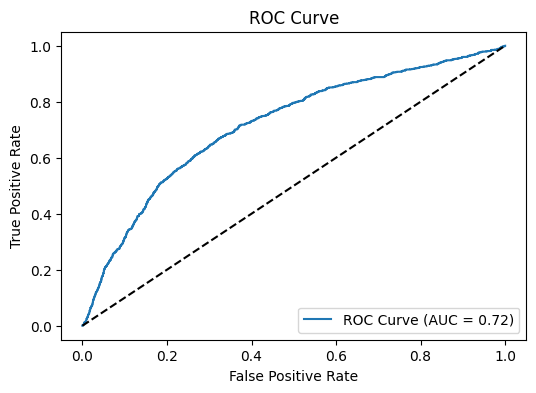

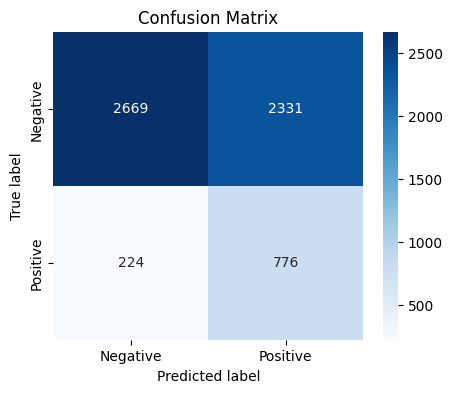

In [18]:
# Test RNN with Attention on Pagerank summarised texts
train_and_test('RNN_Attention', train_sequences_pagerank, train_labels, test_sequences_pagerank, test_labels, input_shape=(200,), vocab_size=vocab_size_pagerank, embedding_dim=128)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5383 - loss: 0.6867
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6943 - loss: 0.6093
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7669 - loss: 0.5117
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8520 - loss: 0.3849
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9357 - loss: 0.2228
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9829 - loss: 0.1027
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9969 - loss: 0.0448
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9993 - loss: 0.0208
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9997 - loss: 0.0102
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9997 - loss: 0.0059
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step

=== Evaluation Metrics ===
Accuracy: 0.5843
Precision: 0.2583
Recall: 0.7980
F1_score: 0.3902
Roc_auc: 0.7518


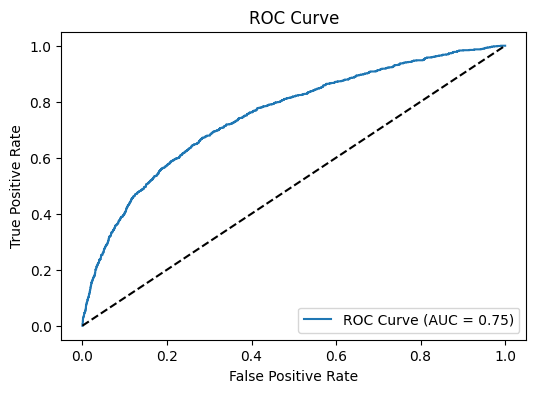

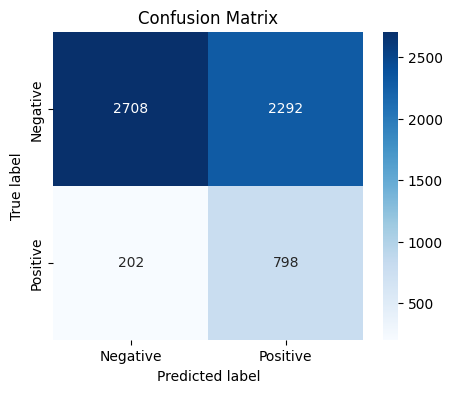

In [9]:
# Test CNN with Pagerank summarised texts
train_and_test('CNN', train_sequences_pagerank, train_labels, test_sequences_pagerank, test_labels, input_shape=(200,), vocab_size=vocab_size_pagerank, embedding_dim=128)

Epoch 1/10


/Users/venessa/Desktop/5246project/cs5246env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.5463 - loss: 0.6846
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.6897 - loss: 0.5765
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.7413 - loss: 0.5174
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.7675 - loss: 0.4767
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 340ms/step - accuracy: 0.8053 - loss: 0.4182
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - accuracy: 0.8517 - loss: 0.3434
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 397ms/step - accuracy: 0.8754 - loss: 0.2769
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 364ms/step - accuracy: 0.9135 - loss: 0.2066
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 362ms/step - accuracy: 0.9391 - loss: 0.1536
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 346ms/step - accuracy: 0.9457 - loss: 0.1334
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step

=== Evaluation Metrics ===
Accuracy: 0.6077
Precision: 0.2638
Recall: 0.7560
F1_score: 0.3911
Roc

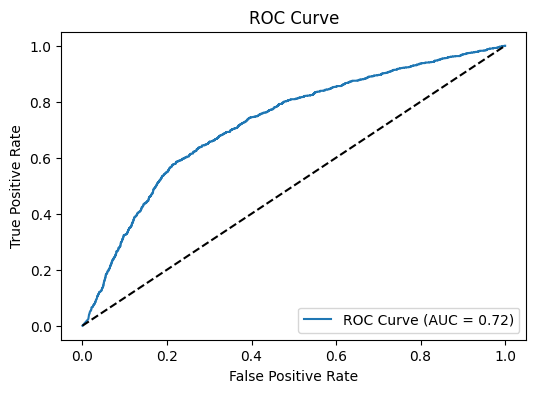

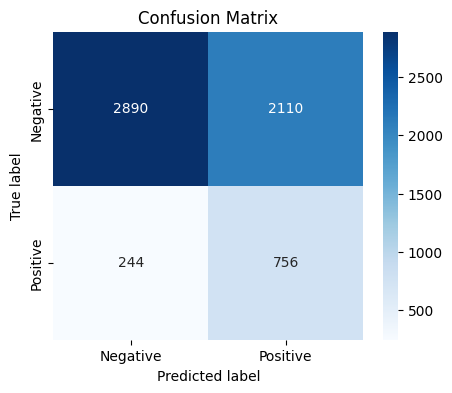

In [10]:
# Test CNN with Attention on Pagerank summarised data
train_and_test('CNN_Attention', train_sequences_pagerank, train_labels, test_sequences_pagerank, test_labels, input_shape=(200,), vocab_size=vocab_size_pagerank, embedding_dim=128)

In [ ]:
# Test Transformer with Pagerank summarised data
train_and_test('Transformer', train_sequences_pagerank, train_labels, test_sequences_pagerank, test_labels, input_shape=(200,), vocab_size=vocab_size_pagerank, embedding_dim=128)